#  简介
前文已经学习了 PPO、SAC 等经典的深度强化学习算法，大部分算法都能在各自的任务中取得比较好的效果，**但是它们都局限在单个任务上**，换句话说，对于训练完的算法，在使用时它们都只能完成一个特定的任务。

**如果面对较为复杂的复合任务，之前的强化学习算法往往不容易训练出有效的策略。**

本章将介绍**目标导向的强化学习**（goal-oriented reinforcement learning，GoRL）以及该类别下的一种经典算法 HER。

GoRL 可以学习一个策略，使其可以在不同的目标（goal）作为条件下奏效，以此来解决较为复杂的决策任务。

# 问题定义

在介绍概念之前，**先介绍一个目标导向的强化学习的实际场景。**

- 例如，策略π要操控机械臂抓取桌子上的一个物体。**值得注意的是，每一次任务开始，物体的位置可能是不同的，也就是说，智能体需要完成一系列相似并不同的任务。**

**在使用传统的强化学习算法时，采用单一策略只能抓取同一个位置的物体。对于不同的目标位置，要训练多个策略。**

**想象一下，在悬崖漫步环境中，若目标位置变成了右上角，便只能重新训练一个策略。同一个策略无法完成一系列不同的目标。**



接下来讨论 GoRL 的数学形式。有别于一般的强化学习算法中定义的马尔可夫决策过程，在目标导向的强化学习中，使用一个扩充过的元组 <S,A,P,$r_g,G,φ$ > 来定义 MDP，

其中，
- S是状态空间，
- A是动作空间，
- P是状态转移函数，
- G是目标空间，
- φ是一个将状态s从状态空间映射为目标空间内的一个目标g的函数，
- $r_g$是奖励函数，与目标g有关。

接下来详细介绍目标导向的强化学习中与一般强化学习不同的概念。




### 首先是补充的目标空间G和目标g。

**在目标导向的强化学习中，任务是由目标定义的，并且目标本身是和状态s相关的，可以将一个状态s使用映射函数φ映射为目标 φ(s) ∈ G。** 

**继续使用之前机械臂抓取物体的任务作为例子：**
- 状态s中包含了机械臂的力矩、物体的位置等信息。
- **因为任务是抓取物体，所以规定目标g是物体的位置**，此时映射函数φ相当于一个从状态s中提取物体位置的函数。

然后介绍奖励函数，奖励函数不仅与状态s和动作a相关，在目标导向强化学习中，还与设定的目标相关，以下是其中一种常见的形式：

In [1]:
from IPython.display import Image

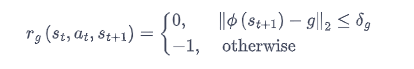

In [2]:
Image(filename='./target_reward.png')

- $δ_g$是一个比较小的值，**表示到达目标附近就不会受到的惩罚。**

在目标导向强化学习中，由于对于不同的目标，奖励函数是不同的，因此状态价值函数V(s,g)也是基于目标的，动作状态价值函数Q(s,a,g)同理。

接下来介绍目标导向的强化学习的优化目标。定义$v_0$为环境中初始状态$s_0$与目标g的联合分布，那么 GoRL 的目标为优化策略π(a|s,g)，使以下目标函数最大化： 

$ E_{(s_0,g)∼v_0}[V^π(s_0,g)] $

# HER 算法（事后经验回放）

根据 19.2 节的定义，可以发现**目标导向的强化学习的奖励往往是非常稀疏的**。
- 由于智能体在训练初期难以完成目标而只能得到的-1奖励，从而使整个算法的训练速度较慢。

那么，有没有一种方法能**有效地利用这些“失败”的经验呢？**

从这个角度出发，**事后经验回放（hindsight experience replay，HER）**算法于 2017 年神经信息处理系统（Neural Information Processing Systems，NeurIPS）大会中被提出，**成为 GoRL 的一大经典方法。**


- 假设现在使用策略在环境中以为g目标进行探索，得到了这么一条轨迹：$s_1,s_2,...,s_T$，并且g≠$s_1,s_2,...,s_T$。这意味着这整一条轨迹上，我们得到的奖励值都是-1，这对我们的训练起到的帮助很小。

- 那么，**如果我们换一个目标$g′$来重新审视整条轨迹呢？**换句话说，**虽然没有达到目标g**，但是策略在探索的过程中，完成了$s_1,s_2,...,s_T$等对应的目标，即完成了$φ(s_1),φ(s_2),...,φ(s_T)$ 等目标。如果用这些目标将原先的目标g替换成新的目标$g′$，**重新计算轨迹中的奖励值，就能使策略从失败的经验中得到对训练有用的信息**。

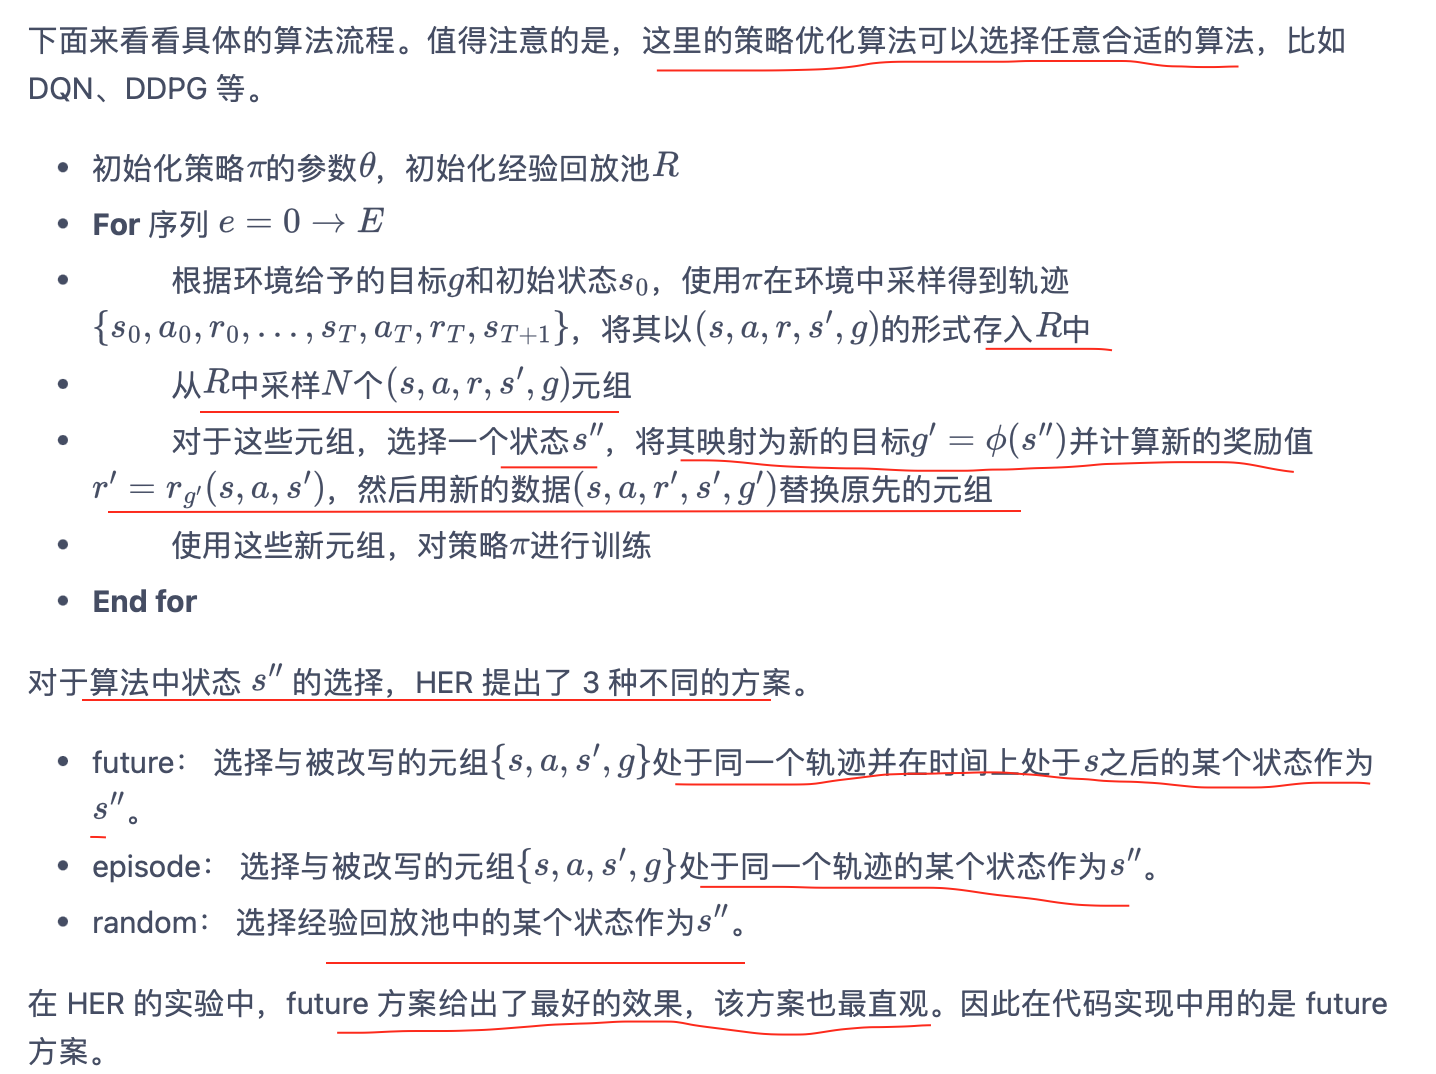

In [4]:
Image(filename='./her_step.png')

# HER 代码实践

**接下来看看如何实现 HER 算法:**
- 首先定义一个简单二维平面上的环境。
  - 在一个二维网格世界上，每个维度的位置范围是[0,5]，
  - 在每一个序列的初始，智能体都处于的位置(0,0)，
  - **环境将自动从3.5≤x , y≤4.5的矩形区域内生成一个目标。**
  - 每个时刻智能体可以选择纵向和横向分别移动[-1,1]作为这一时刻的动作。
  - **当智能体距离目标足够近的时候**，它将收到的奖励并结束任务，否则奖励为-1。
  - 每一条序列的最大长度为 50。
  
  环境示意图如图 19-1 所示。

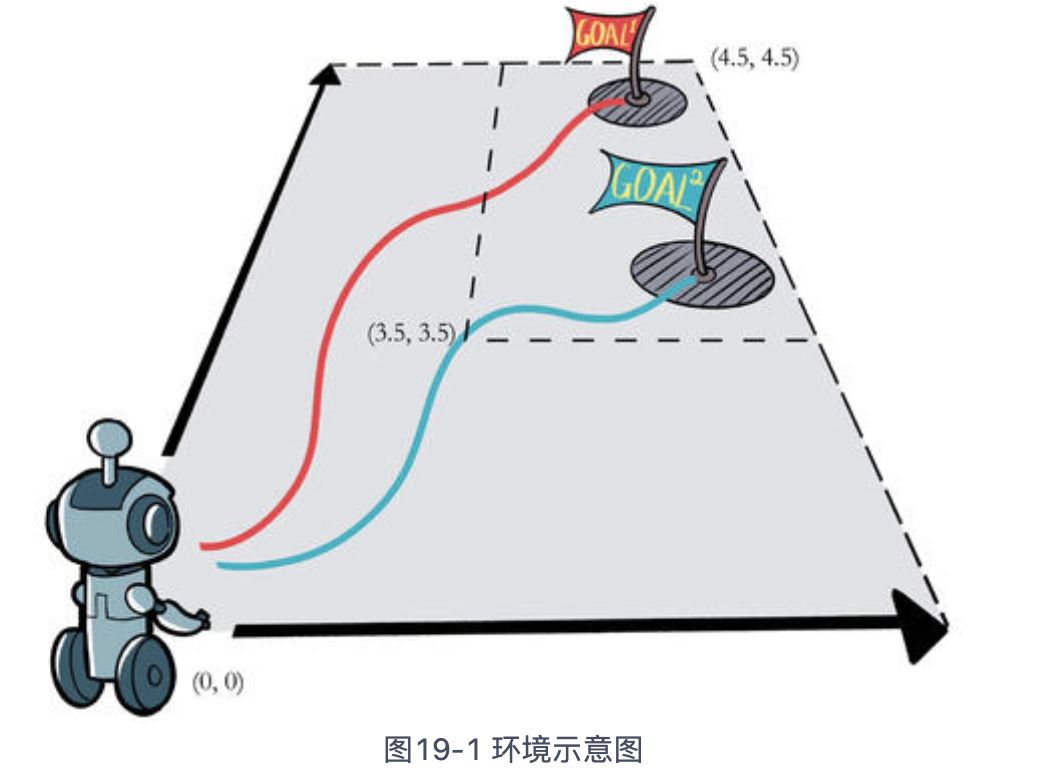

In [8]:
Image(filename='./goal.png',width=600)

In [11]:
import random

# 生成一个在 [1.5, 4.5) 范围内的随机浮点数
random_number = random.uniform(-0.5, 0.5)
print(random_number)

-0.14305285744043172


In [13]:
import numpy as np

# 创建两个数组
array1 = np.array([[1, 2], [3, 4]])
array2 = np.array([[5, 6], [7, 8]])

# 水平堆叠数组
# 这个函数接受一系列数组作为输入，并将它们水平地（即沿着第二个轴）拼接在一起，形成一个新的数组。
hstacked_array = np.hstack((array1, array2))

print(hstacked_array)

[[1 2 5 6]
 [3 4 7 8]]


In [14]:
import numpy as np

# 创建一个数组
array = np.array([1, 2, 3, 4, 5])

# 将数组中的元素限制在2到4之间
clipped_array = np.clip(array, 2, 4)

# 如你所见，数组中小于2的元素被设置为2，大于4的元素被设置为4。
print(clipped_array)

[2 2 3 4 4]


In [15]:
import numpy as np

# 创建一个数组
array = np.array([1, 4, 9, 16])

# 计算数组中每个元素的平方根
sqrt_array = np.sqrt(array)

print(sqrt_array)

[1. 2. 3. 4.]


In [16]:
import numpy as np

# 创建一个数组
array = np.array([1, 2, 3, 4])

# 计算数组中每个元素的平方
squared_array = np.square(array)

print(squared_array)

[ 1  4  9 16]


In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt


class WorldEnv:
    def __init__(self):
        self.distance_threshold = 0.15 # 在目标附近
        self.action_bound = 1

    def reset(self):  # 重置环境
        # 生成一个目标状态, 坐标范围是[3.5～4.5, 3.5～4.5]
        self.goal = np.array(
            [4 + random.uniform(-0.5, 0.5), 4 + random.uniform(-0.5, 0.5)])
        self.state = np.array([0, 0])  # 初始状态
        self.count = 0
        return np.hstack((self.state, self.goal))

    def step(self, action):
        action = np.clip(action, -self.action_bound, self.action_bound)
        
        x = max(0, min(5, self.state[0] + action[0]))
        y = max(0, min(5, self.state[1] + action[1]))
        
        self.state = np.array([x, y])
        self.count += 1

        dis = np.sqrt(np.sum(np.square(self.state - self.goal)))
        
        reward = -1.0 if dis > self.distance_threshold else 0
        
        if dis <= self.distance_threshold or self.count == 50:
            done = True
        else:
            done = False

        return np.hstack((self.state, self.goal)), reward, done

### 接下来实现 DDPG 算法中用到的与 Actor 网络和 Critic 网络的网络结构相关的代码

In [ ]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return torch.tanh(self.fc3(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc2(F.relu(self.fc1(cat))))
        return self.fc3(x)

In [18]:
import torch

# 创建两个张量
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[5, 6], [7, 8]])

# 沿着第 0 维拼接（垂直拼接）
result_0 = torch.cat((a, b), dim=0)
print("沿着第 0 维拼接：")
print(result_0)
# 输出：
# tensor([[1, 2],
#         [3, 4],
#         [5, 6],
#         [7, 8]])

# 沿着第 1 维拼接（水平拼接）
result_1 = torch.cat((a, b), dim=1)
print("沿着第 1 维拼接：")
print(result_1)
# 输出：
# tensor([[1, 2, 5, 6],
#         [3, 4, 7, 8]])

沿着第 0 维拼接：
tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])
沿着第 1 维拼接：
tensor([[1, 2, 5, 6],
        [3, 4, 7, 8]])


### 在定义好 Actor 和 Critic 的网络结构之后，来看一下 DDPG 算法的代码。

这部分代码和 13.3 节中的代码基本一致，主要区别在于 13.3 节中的 DDPG 算法是在倒立摆环境中运行的，动作只有 1 维，而这里的环境中动作有 2 维，导致一小部分代码不同。

读者可以先思考一下此时应该修改哪一部分代码，然后自行对比，就能找到不同之处。

In [19]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, sigma, tau, gamma, device):
        self.action_dim = action_dim
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim,
                               action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim,
                                      action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim,
                                       action_dim).to(device)
        # 初始化目标价值网络并使其参数和价值网络一样
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并使其参数和策略网络一样
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_bound = action_bound
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).detach().cpu().numpy()[0]
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),net.parameters()):
            # copy_它是一个原地操作（in-place operation），即它会直接修改调用它的张量的内容，而不是创建一个新的张量。
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states,
                                           self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        
        # MSE损失函数(平均损失)
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states, actions), q_targets))
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 策略网络就是为了使Q值最大化
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

### 接下来定义一个特殊的经验回放池，
- 此时回放池内不再存储每一步的数据，而是存储一整条轨迹。

**这是 HER 算法中的核心部分**，

**之后可以用 HER 算法从该经验回放池中构建新的数据来帮助策略训练。**

In [ ]:
class Trajectory:
    ''' 用来记录一条完整轨迹 '''
    def __init__(self, init_state):
        self.states = [init_state]
        self.actions = []
        self.rewards = []
        self.dones = []
        self.length = 0

    def store_step(self, action, state, reward, done):
        self.actions.append(action)
        self.states.append(state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.length += 1

''' 存储轨迹的经验回放池 '''
class ReplayBuffer_Trajectory:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add_trajectory(self, trajectory):
        self.buffer.append(trajectory)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size, use_her, dis_threshold=0.15, her_ratio=0.8):
        batch = dict(states=[],
                     actions=[],
                     next_states=[],
                     rewards=[],
                     dones=[])
        
        for _ in range(batch_size):
            traj = random.sample(self.buffer, 1)[0]
            # 在轨迹中随机重新选择一个状态
            step_state = np.random.randint(traj.length)
            
            state = traj.states[step_state]
            next_state = traj.states[step_state + 1]
            action = traj.actions[step_state]
            reward = traj.rewards[step_state]
            done = traj.dones[step_state]

            if use_her and np.random.uniform() <= her_ratio:
                # 在当前时间步之后的轨迹中随机选择一个时间步 step_goal，并将其状态的前两个元素（通常是位置信息）作为新的目标。
                step_goal = np.random.randint(step_state + 1, traj.length + 1)
                goal = traj.states[step_goal][:2]  # 使用HER算法的future方案设置目标
                
                # 计算两点之间的距离
                dis = np.sqrt(np.sum(np.square(next_state[:2] - goal)))
                
                reward = -1.0 if dis > dis_threshold else 0
                done = False if dis > dis_threshold else True
                state = np.hstack((state[:2], goal))
                next_state = np.hstack((next_state[:2], goal))

            batch['states'].append(state)
            batch['next_states'].append(next_state)
            batch['actions'].append(action)
            batch['rewards'].append(reward)
            batch['dones'].append(done)

        batch['states'] = np.array(batch['states'])
        batch['next_states'] = np.array(batch['next_states'])
        batch['actions'] = np.array(batch['actions'])
        return batch

#### 最后，便可以开始在这个有目标的环境中运行采用了 HER 的 DDPG 算法，一起来看一下效果吧

In [ ]:
actor_lr = 1e-3
critic_lr = 1e-3

hidden_dim = 128
state_dim = 4
action_dim = 2

action_bound = 1
sigma = 0.1
tau = 0.005
gamma = 0.98
num_episodes = 2000
n_train = 20
batch_size = 256
minimal_episodes = 200
buffer_size = 10000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

env = WorldEnv()

replay_buffer = ReplayBuffer_Trajectory(buffer_size)

agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                # 选择动作
                action = agent.take_action(state)
                # 执行动作
                state, reward, done = env.step(action)
                episode_return += reward
                # 存储轨迹，直到结束
                traj.store_step(action, state, reward, done)
            # 将轨迹添加到buffer中
            replay_buffer.add_trajectory(traj)
            return_list.append(episode_return)
            # 采样
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    transition_dict = replay_buffer.sample(batch_size, True)
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG with HER on {}'.format('GridWorld'))
plt.show()

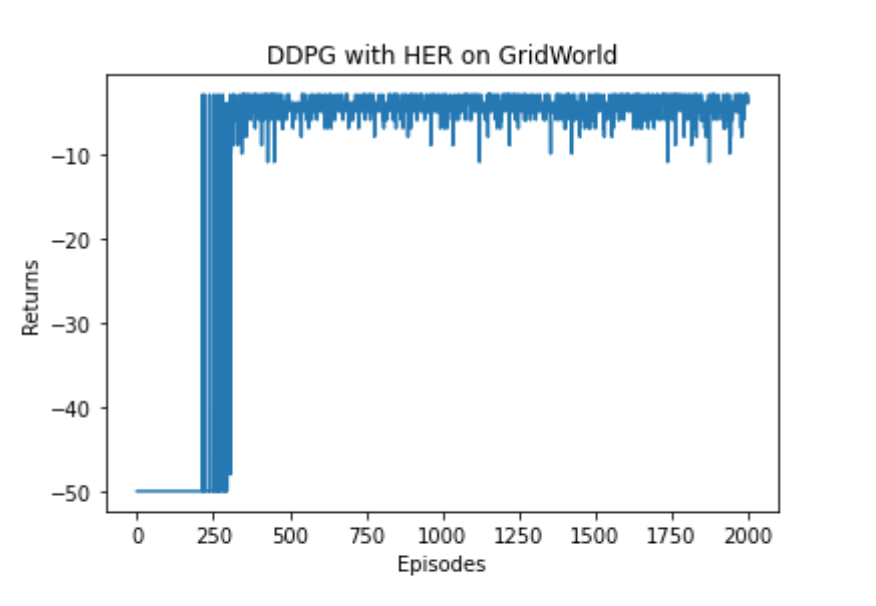

In [20]:
Image(filename='./her_cahrt.png')

### 接下来尝试不采用 HER 重新构造数据，而是直接使用收集的数据训练一个策略，看看是什么效果。

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()

replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)
            replay_buffer.add_trajectory(traj)
            return_list.append(episode_return)
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    # 和使用HER训练的唯一区别
                    transition_dict = replay_buffer.sample(batch_size, False)
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG without HER on {}'.format('GridWorld'))
plt.show()

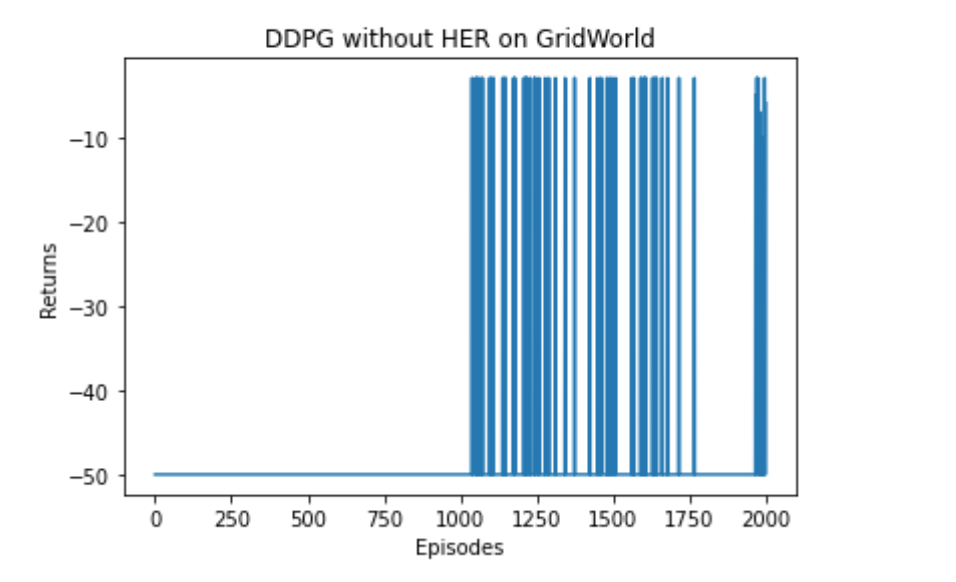

In [23]:
Image(filename='./without_her_chart.png', width= 500)

**通过实验对比，可以观察到使用 HER 算法后，效果有显著提升。**

**这里 HER 算法的主要好处是通过重新对历史轨迹设置其目标（使用 future 方案）而使得奖励信号更加稠密，进而从原本失败的数据中学习到使“新任务”成功的经验，提升训练的稳定性和样本效率。**

### 本章介绍了目标导向的强化学习（GoRL）的基本定义，以及一个解决 GoRL 的有效的经典算法 HER。

通过代码实践，HER 算法的效果得到了很好的呈现。**我们从 HER 的代码实践中还可以领会一种思维方式，即可以通过整条轨迹的信息来改善每个转移片段带给智能体策略的学习价值。**
- 例如，在 HER 算法的 future 方案中，采样当前轨迹后续的状态作为目标，然后根据下一步状态是否离目标足够近来修改当前步的奖励信号。

- 此外，HER 算法只是一个经验回放的修改方式，并没有对策略网络和价值网络的架构做出任何修改。

而在后续的部分 GoRL 研究中，策略函数和动作价值函数会被显式建模成π(a|s,g)和Q(s,a,g)，**即构建较为复杂的策略架构，使其直接知晓当前状态和目标，并使用更大的网络容量去完成目标。** 有兴趣的读者可以自行查阅相关的文献。

## 19.6 参考文献

[1] ANDRYCHOWICZ M, WOLSKI F, RAY A, et al. Hindsight Experience Replay [J]. Advances in neural information processing systems, 2017: 5055-5065.

[2] FLORENSA C, HELD D, GENG X Y, et al. Automatic goal generation for reinforcement learning agents [C]// International conference on machine learning, PMLR, 2018: 1515-1528.

[3] REN Z Z, DONG K, ZHOU Y, et al. Exploration via Hindsight Goal Generation [J]. Advances in neural information processing systems 2019, 32: 13485-13496.

[4] PITIS S, CHAN H, ZHAO S, et al. Maximum entropy gain exploration for long horizon multi-goal reinforcement learning [C]// International conference on machine learning, PMLR, 2020: 7750-7761.